## Intro
When we expanded the dataset to include all of downtown Norfolk, some of the new flooding events recorded at the expanded circle of points considered occurred when there was very little or no rainfall recorded in the three days previous to the date of the recorded flood. This is some code to examine the flooding events where no rainfall occurred but flooding was still recorded

In [1]:
from db_scripts.get_server_data import data_dir
import pandas as pd
import matplotlib.pyplot as plt
import math
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import numpy as np

In [2]:
df = pd.read_csv("{}{}".format(data_dir, "reformatted_for_model_downtown_nor.csv"))

In [3]:
print df.head()

   Unnamed: 0    Datetime  tide_level  rainfall_daily_total  \
0           0  2010-01-02    0.352125                   0.0   
1           1  2010-01-03   -0.853333                   0.0   
2           2  2010-01-04   -0.789292                   0.0   
3           3  2010-01-05   -0.235708                   0.0   
4           4  2010-01-06   -0.295375                   0.0   

   rainfall_daily_max_15  rainfall_prev_3_days  shallow_well_depth flooded  
0                    0.0                   NaN            3.236243   False  
1                    0.0                  0.06            3.125281   False  
2                    0.0                  0.00            2.989199   False  
3                    0.0                  0.00            2.871405   False  
4                    0.0                  0.00            2.752379   False  


### Get the events that had very little rainfall (less than 0.1 in for the past three days).

In [11]:
flooded_df = df[(df.flooded==True) & (df['rainfall_prev_3_days'] < 0.1)]
flooded_df

,Unnamed: 0,Datetime,tide_level,rainfall_daily_total,rainfall_daily_max_15,rainfall_prev_3_days,shallow_well_depth,flooded
2090,2090,2015-09-23,1.571292,0.00,0.00,5.000000e-02,2.557358,True
2168,2168,2015-12-10,0.481792,0.02,0.01,3.000000e-02,3.424951,True
2229,2229,2016-02-09,1.607417,0.01,0.01,9.000000e-02,5.014552,True
2396,2396,2016-07-25,0.104667,0.00,0.00,-2.211772e-15,3.149425,True
2433,2433,2016-08-31,0.332583,0.00,0.00,-2.289835e-15,2.602684,True
2468,2468,2016-10-05,1.870792,0.00,0.00,-4.440892e-16,3.515013,True


Why did flooding happen during these days? Was the tide particularly high? the groundwater? Let's look at the average for the other flooded days and all the days.

1.17293863636
0.158847166533


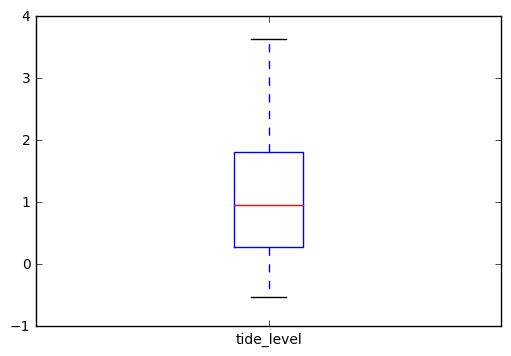

In [23]:
print df[df.flooded]['tide_level'].mean()
print df['tide_level'].mean()
df[df.flooded]['tide_level'].plot.box()
plt.show()

So this is somewhat instructive. We have 3 days above the average tide level on the days that it flooded.

2.73269740854
2.18574436618


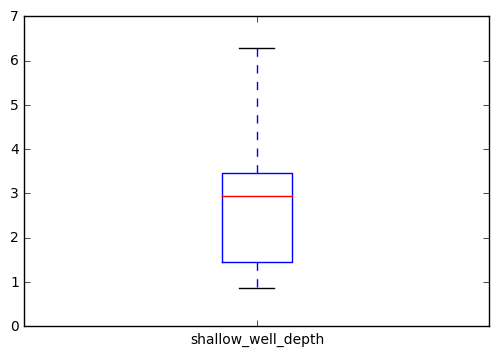

In [24]:
print df[df.flooded]['shallow_well_depth'].mean()
print df['shallow_well_depth'].mean()
df[df.flooded]['shallow_well_depth'].plot.box()
plt.show()

### Get the dates when those events happened to further investigate

In [5]:
no_rain_dates = flooded_df['Datetime']
no_rain_dates.reset_index(drop=True, inplace=True)

In [6]:
print no_rain_dates

0    2015-09-23
1    2015-12-10
2    2016-02-09
3    2016-07-25
4    2016-08-31
5    2016-10-05
Name: Datetime, dtype: object


### Now we import all the flooding events

In [7]:
all_df = pd.read_csv('{}norfolk_flooded_roads_data/STORM_data_flooded_streets_2010-2016_no_duplicates_clean_lat_lon.csv'.format(data_dir))
all_df['_date'] = pd.to_datetime(all_df['_date'])

### List the locations and how often they flooded on the no rainfall dates

In [8]:
no_rain_floods = all_df[all_df['_date'].isin(no_rain_dates)]
locs = no_rain_floods['location']
print len(locs.unique()), " total locations where this has happened"
locs.value_counts()

12  total locations where this has happened


426 GRANBY STREET                      2
7TH BAY STREET & PRETTY LAKE AVENUE    2
WATER STREET & PARK AVENUE             2
GRANBY STREET & SHIRLEY AVENUE         1
DUKE STREET & W OLNEY ROAD             1
4002 GRANBY STREET                     1
2205 MCKANN AVENUE                     1
800 BLOCK OF ALMA DRIVE                1
8000 WESTCLIFF DRIVE                   1
QUEENS WAY & SHIRLEY AVENUE            1
DELAWARE AVENUE & LLEWELLYN AVENUE     1
401 MONTICELLO AVENUE                  1
Name: location, dtype: int64

### I would like to see which of these are in our Downtown Norfolk points subset

In [9]:
subset_df = pd.read_csv('{}subset_points_data.txt'.format(data_dir))
subset_locs = locs[locs.isin(subset_df['location'])]
subset_locs.value_counts()

426 GRANBY STREET                 2
WATER STREET & PARK AVENUE        2
GRANBY STREET & SHIRLEY AVENUE    1
QUEENS WAY & SHIRLEY AVENUE       1
DUKE STREET & W OLNEY ROAD        1
401 MONTICELLO AVENUE             1
Name: location, dtype: int64

### Plot the points on a map

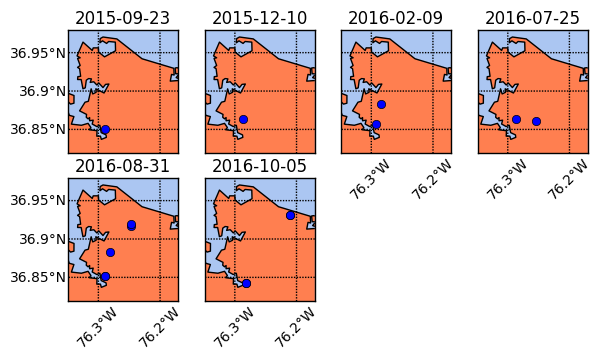

In [10]:
ncols = 4
nrows = int(math.ceil(float(len(no_rain_dates))/ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6.75,3.5))
ax_list = axs.ravel()
for i in range(len(no_rain_dates)):
    plot_df = all_df[all_df['_date'] == no_rain_dates[i]]
  # comment next line out to plot all 12 locations where such floods have occurred
#     plot_df = plot_df[plot_df['location'].isin(subset_locs)]  
    lats = all_df['lat']
    lons = all_df['lon']
    ax = ax_list[i]
    
    m = Basemap(resolution='h', projection='tmerc', lat_0 = lats.mean(), lon_0 = lons.mean(), ax=ax,
                llcrnrlon=lons.min()*1.0004,llcrnrlat=lats.min()*0.9999,
                urcrnrlon=lons.max()*0.9999,urcrnrlat=lats.max()*1.0003)
             
    m.drawcoastlines()
    m.drawmapboundary(fill_color='#abc6f2')
    m.fillcontinents(color = 'coral', lake_color='#abc6f2')
    
    latlabels = [1, 0, 0, 1] if i in [0, 4] else [0, 0, 0, 0]
    lonlabels = [1, 0, 0, 1] if i in [2, 3, 4, 5] else [0, 0, 0, 0]
    m.drawparallels(np.arange(34,38,0.05), labels=latlabels)
    meridians = m.drawmeridians(np.arange(-77, -75, 0.1), labels=lonlabels)
    for mer in meridians:
        try:
            meridians[mer][1][0].set_rotation(45)
        except:
            pass
    
    x,y = m(plot_df['lon'].tolist(), plot_df['lat'].tolist())
    ax.set_title(no_rain_dates[i])
    m.plot(x, y, 'bo', markersize=6)

ax_list[6].axis('off')
ax_list[7].axis('off')
plt.show()